# Principal Component Analysis -- House Price

Step 1: Importing the libraries

In [74]:
# importing required libraries 
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

from scipy import stats
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")


Step 2: Importing the data set

Import the dataset and distributing the dataset into X and y components for data analysis.

In [75]:
# Load  data from CSV
df_train = pd.read_csv("house_train.csv", index_col=0)
df_test = pd.read_csv("house_test.csv", index_col=0)

In [76]:
df_test_id_test = pd.read_csv("house_test.csv")

In [77]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target = 'SalePrice_Log'
    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

Some useful functions

In [78]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [79]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [80]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

Basic information
shape, info, head and describe

In [81]:
# Dataframe dimensions
print(df_train.shape)
print("*"*50)
print(df_test.shape)

(1460, 80)
**************************************************
(1459, 79)


In [82]:
# Column datatypes
print(df_train.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object


In [83]:
# Column datatypes
print(df_train.dtypes)
print("*"*50)
print(df_test.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object
**************************************************
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object


In [84]:
# Display first 5 rows of df_train
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [85]:
# Display first 5 rows of df_test
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [86]:
# Filter and display only df.dtypes that are 'object'
df_train.dtypes[df_train.dtypes == 'object']

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

In [87]:
# Loop through categorical feature names and print each one
for feature in df_train.dtypes[df_train.dtypes == 'object'].index:
    print(feature)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [88]:
# Display the first 10 rows of data
df_train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


In [89]:
# Display last 5 rows of data
df_train.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


Distributions of numeric features

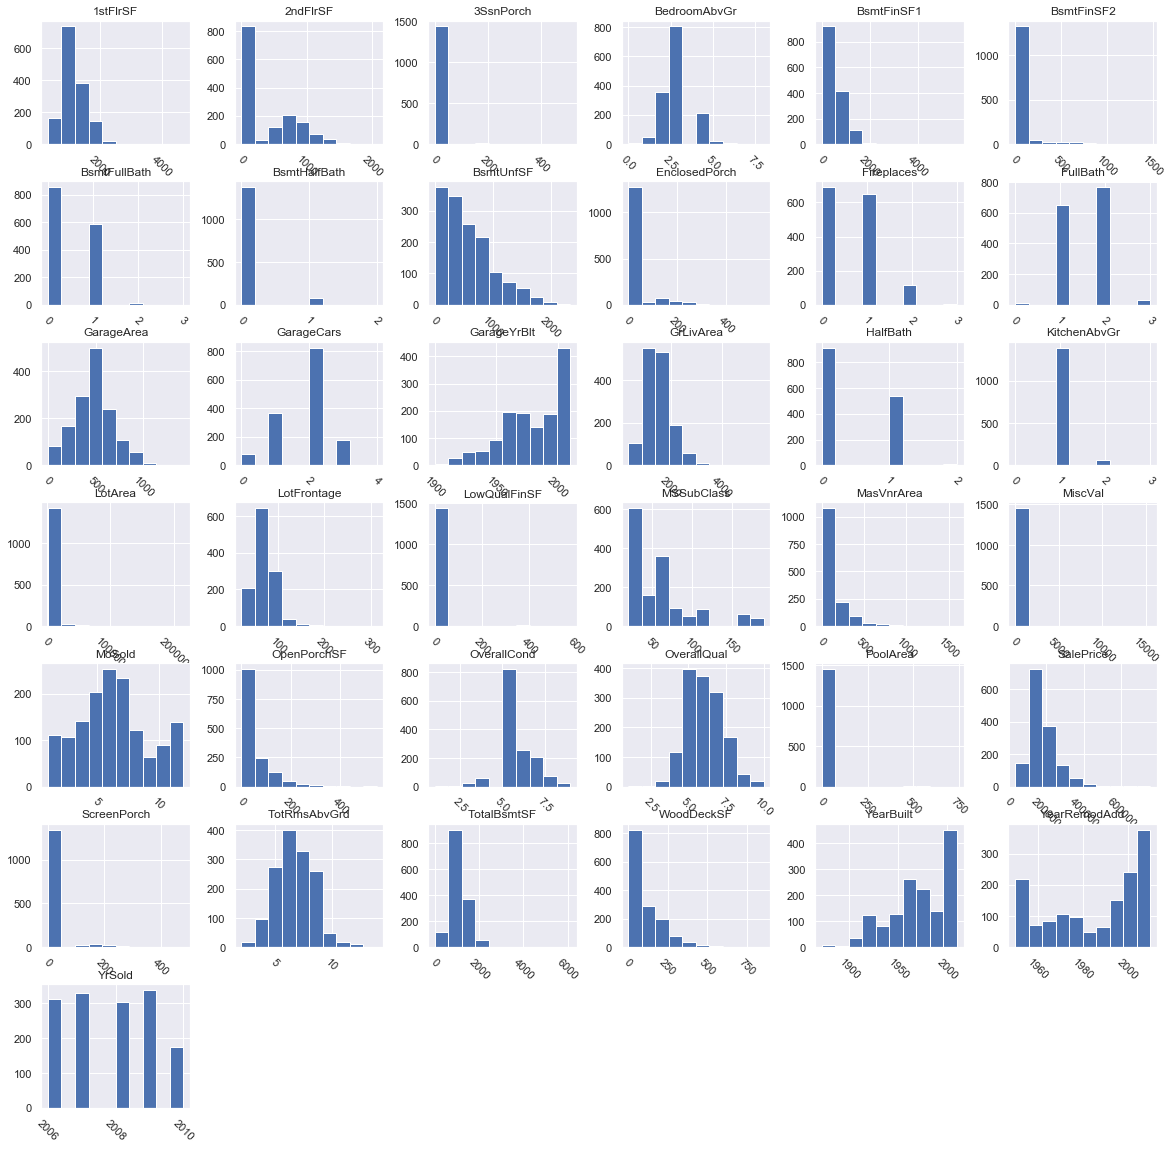

In [90]:
# Plot histogram grid
df_train.hist(figsize=(20,20), xrot=-45)

# Clear the text "residue"
plt.show()

In [91]:
# Summarize numerical features
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [92]:
# Summarize numerical features
df_test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


The target variable : Distribution of SalePrice

Skewness: 1.882876
Kurtosis: 6.536282


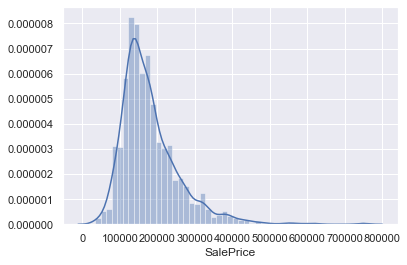

In [93]:
sns.distplot(df_train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

the target variable SalePrice is not normally distributed. This can reduce the performance of the ML models because they assume normal distribution, see sklearn info on preprocessing

Therfore we make a log transformation, the resulting distribution looks much better.

Skewness: 0.121347
Kurtosis: 0.809519


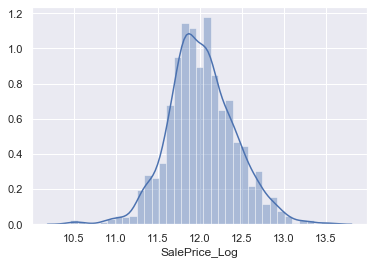

In [94]:
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice'])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())


Display summary statistics for categorical features

In [95]:
# Summarize categorical features
df_train.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


Number of Numerical and Categorical features

In [96]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


Columns of Numerical and Categorical features

In [97]:
#Numerical
print(df_train[numerical_feats].columns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'SalePrice_Log'],
      dtype='object')


In [98]:
#Categorical
print(df_train[categorical_feats].columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


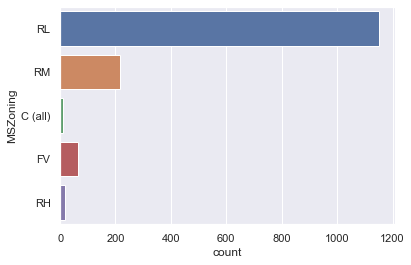

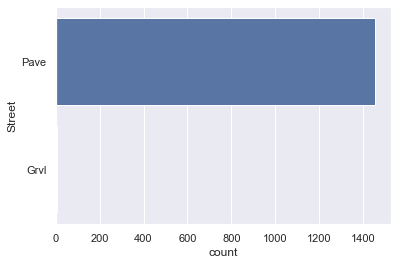

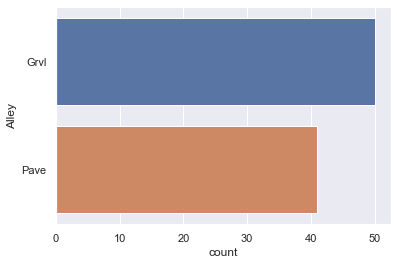

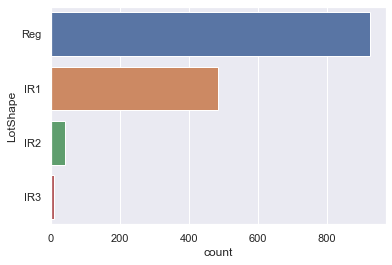

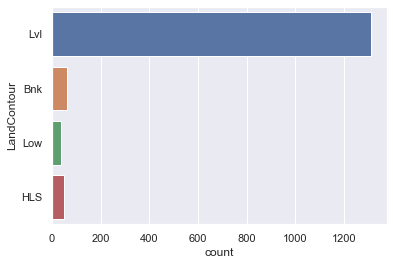

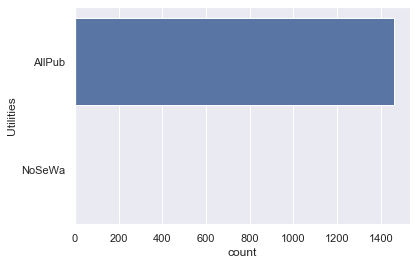

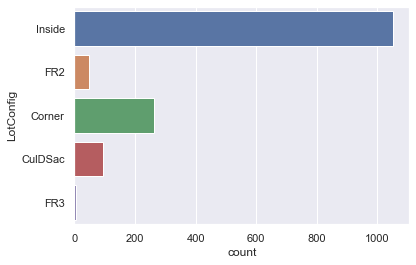

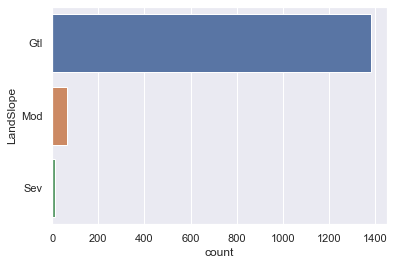

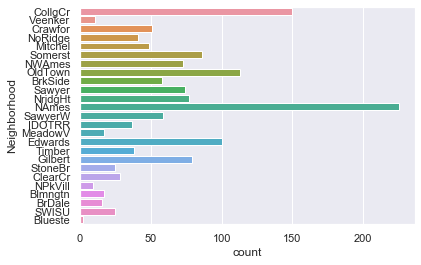

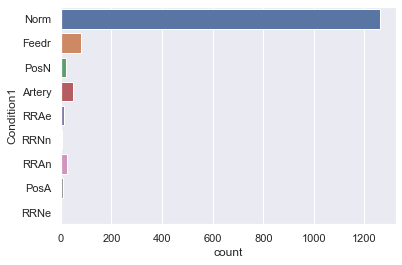

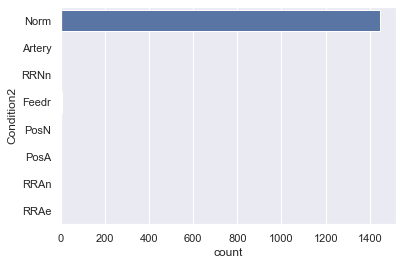

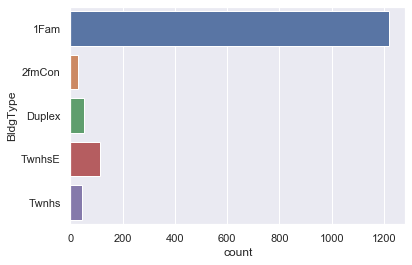

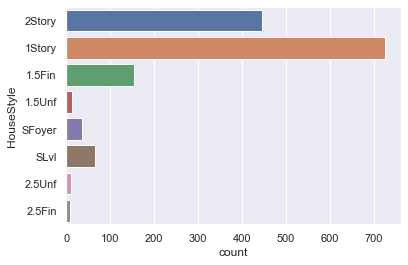

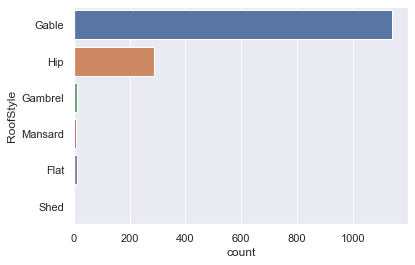

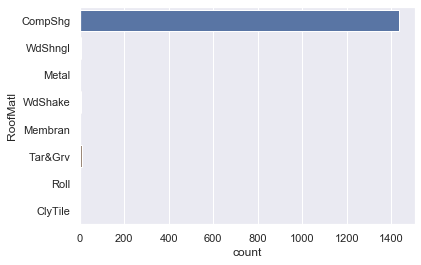

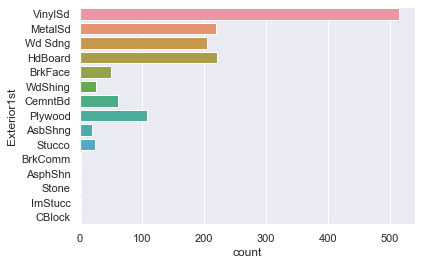

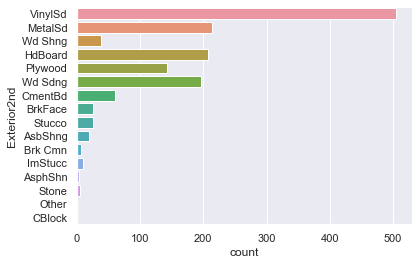

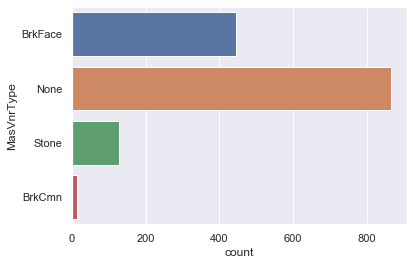

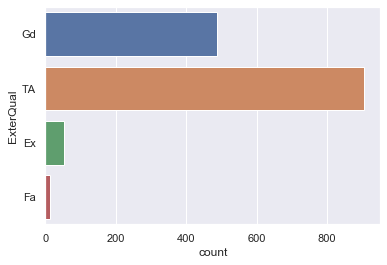

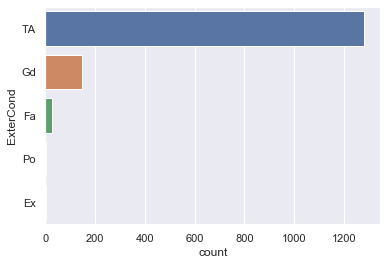

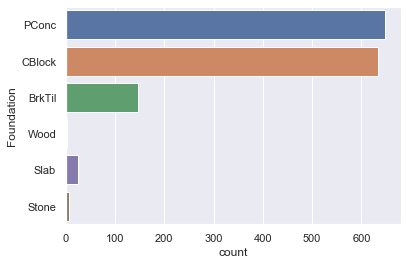

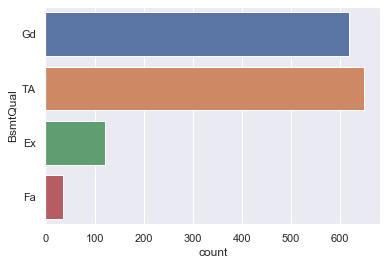

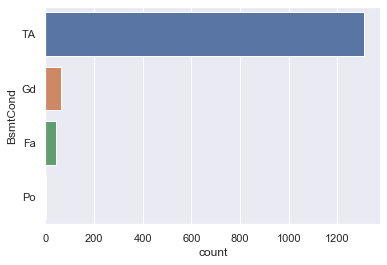

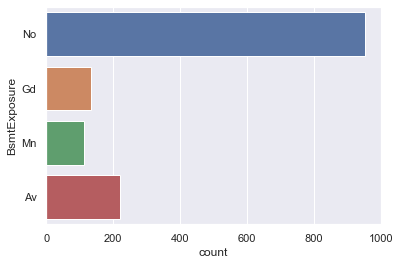

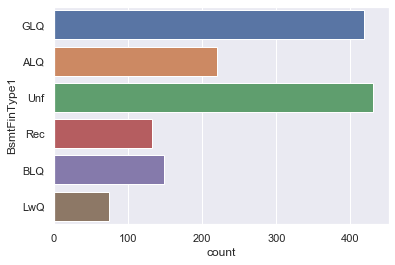

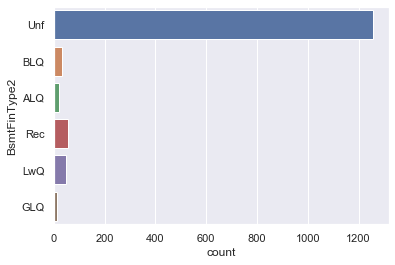

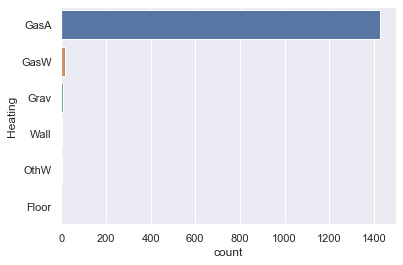

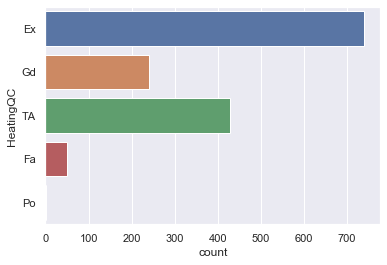

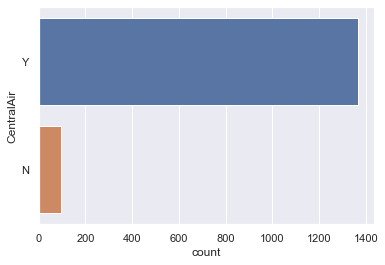

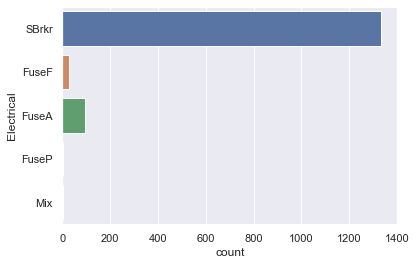

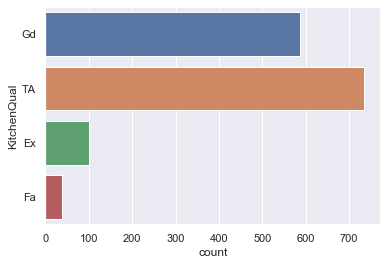

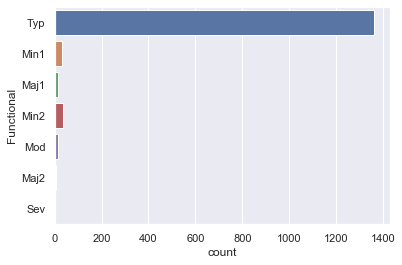

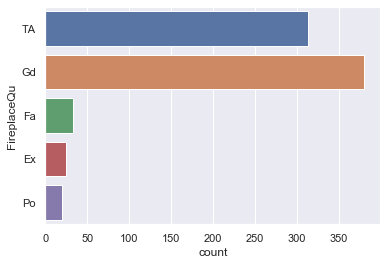

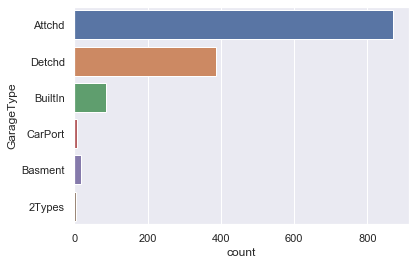

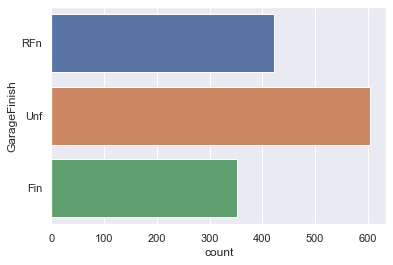

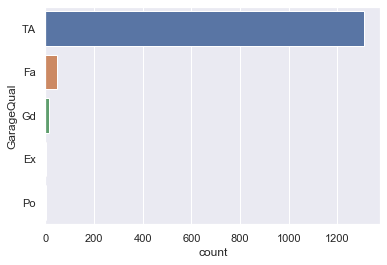

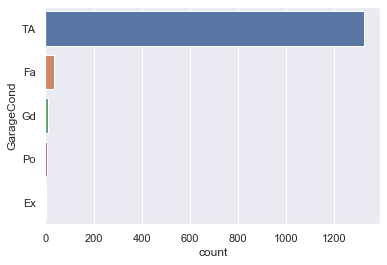

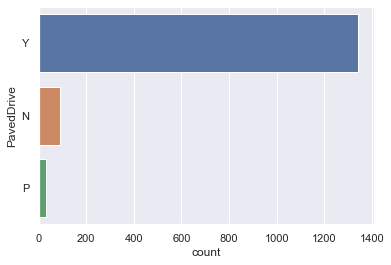

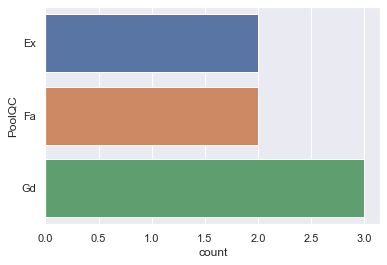

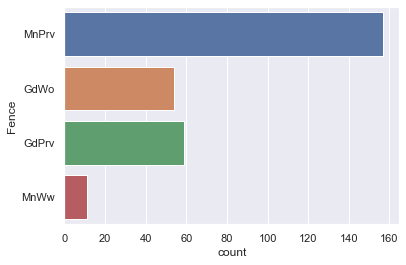

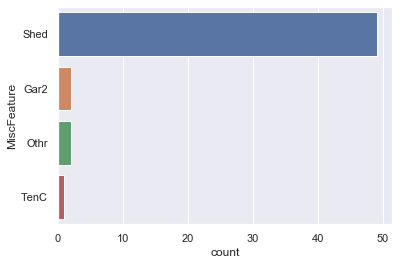

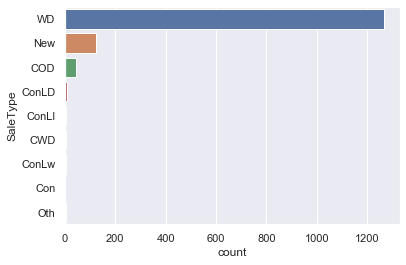

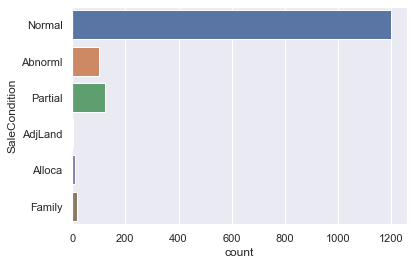

In [99]:
# Plot bar plot for each categorical feature

for feature in df_train.dtypes[df_train.dtypes == 'object'].index:
    sns.countplot(y=feature, data=df_train)
    plt.show()

List of features with missing values

In [100]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageType,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479


Filling missing values For a few columns there is lots of NaN entries. However, reading the data description we find this is not missing data: For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

In [101]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [102]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
BsmtQual,0,0.000000
RoofMatl,0,0.000000


In [103]:
# fillna with mean or mode for the remaining values
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)
df_train.fillna(df_train.mode(), inplace=True)
df_test.fillna(df_test.mode(), inplace=True)

In [104]:
df_train.isnull().sum().sum()

0

In [105]:
df_test.isnull().sum().sum()

0

log transform Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in df_train. Checking for skewness and kurtosis

In [106]:
for col in numerical_feats:
    print(col)
    print("Skewness: %f" % df_train[col].skew())
    print("Kurtosis: %f" % df_train[col].kurt())
    print("*"*50)

MSSubClass
Skewness: 1.407657
Kurtosis: 1.580188
**************************************************
LotFrontage
Skewness: 2.384950
Kurtosis: 21.848165
**************************************************
LotArea
Skewness: 12.207688
Kurtosis: 203.243271
**************************************************
OverallQual
Skewness: 0.216944
Kurtosis: 0.096293
**************************************************
OverallCond
Skewness: 0.693067
Kurtosis: 1.106413
**************************************************
YearBuilt
Skewness: -0.613461
Kurtosis: -0.439552
**************************************************
YearRemodAdd
Skewness: -0.503562
Kurtosis: -1.272245
**************************************************
MasVnrArea
Skewness: 2.676412
Kurtosis: 10.154316
**************************************************
BsmtFinSF1
Skewness: 1.685503
Kurtosis: 11.118236
**************************************************
BsmtFinSF2
Skewness: 4.255261
Kurtosis: 20.113338
***************************************

Skewness: 1.366560
Kurtosis: 4.895121


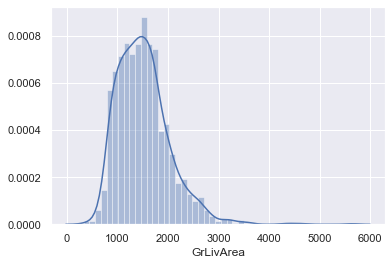

In [107]:
sns.distplot(df_train['GrLivArea']);

#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 12.207688
Kurtosis: 203.243271


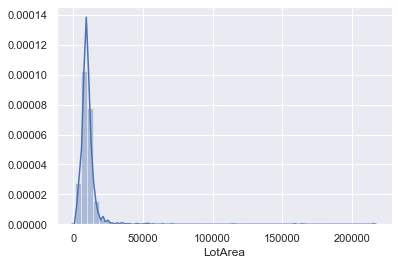

In [108]:
sns.distplot(df_train['LotArea']);

#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

In [109]:
for df in [df_train]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

Skewness: -0.006995
Kurtosis: 0.282603


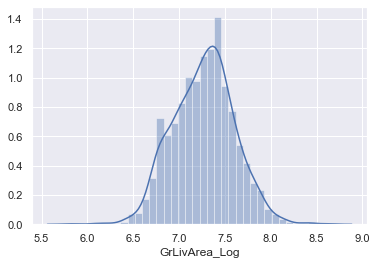

In [110]:
sns.distplot(df_train['GrLivArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % df_train['GrLivArea_Log'].kurt())

Skewness: -0.137994
Kurtosis: 4.713358


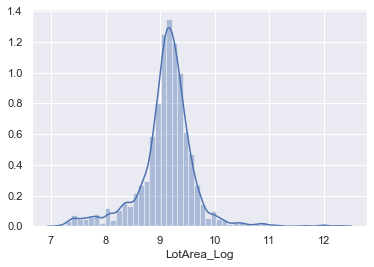

In [111]:
sns.distplot(df_train['LotArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea_Log'].skew())
print("Kurtosis: %f" % df_train['LotArea_Log'].kurt())

Relation of features to target (SalePrice_log)

Plots of relation to target for all numerical features

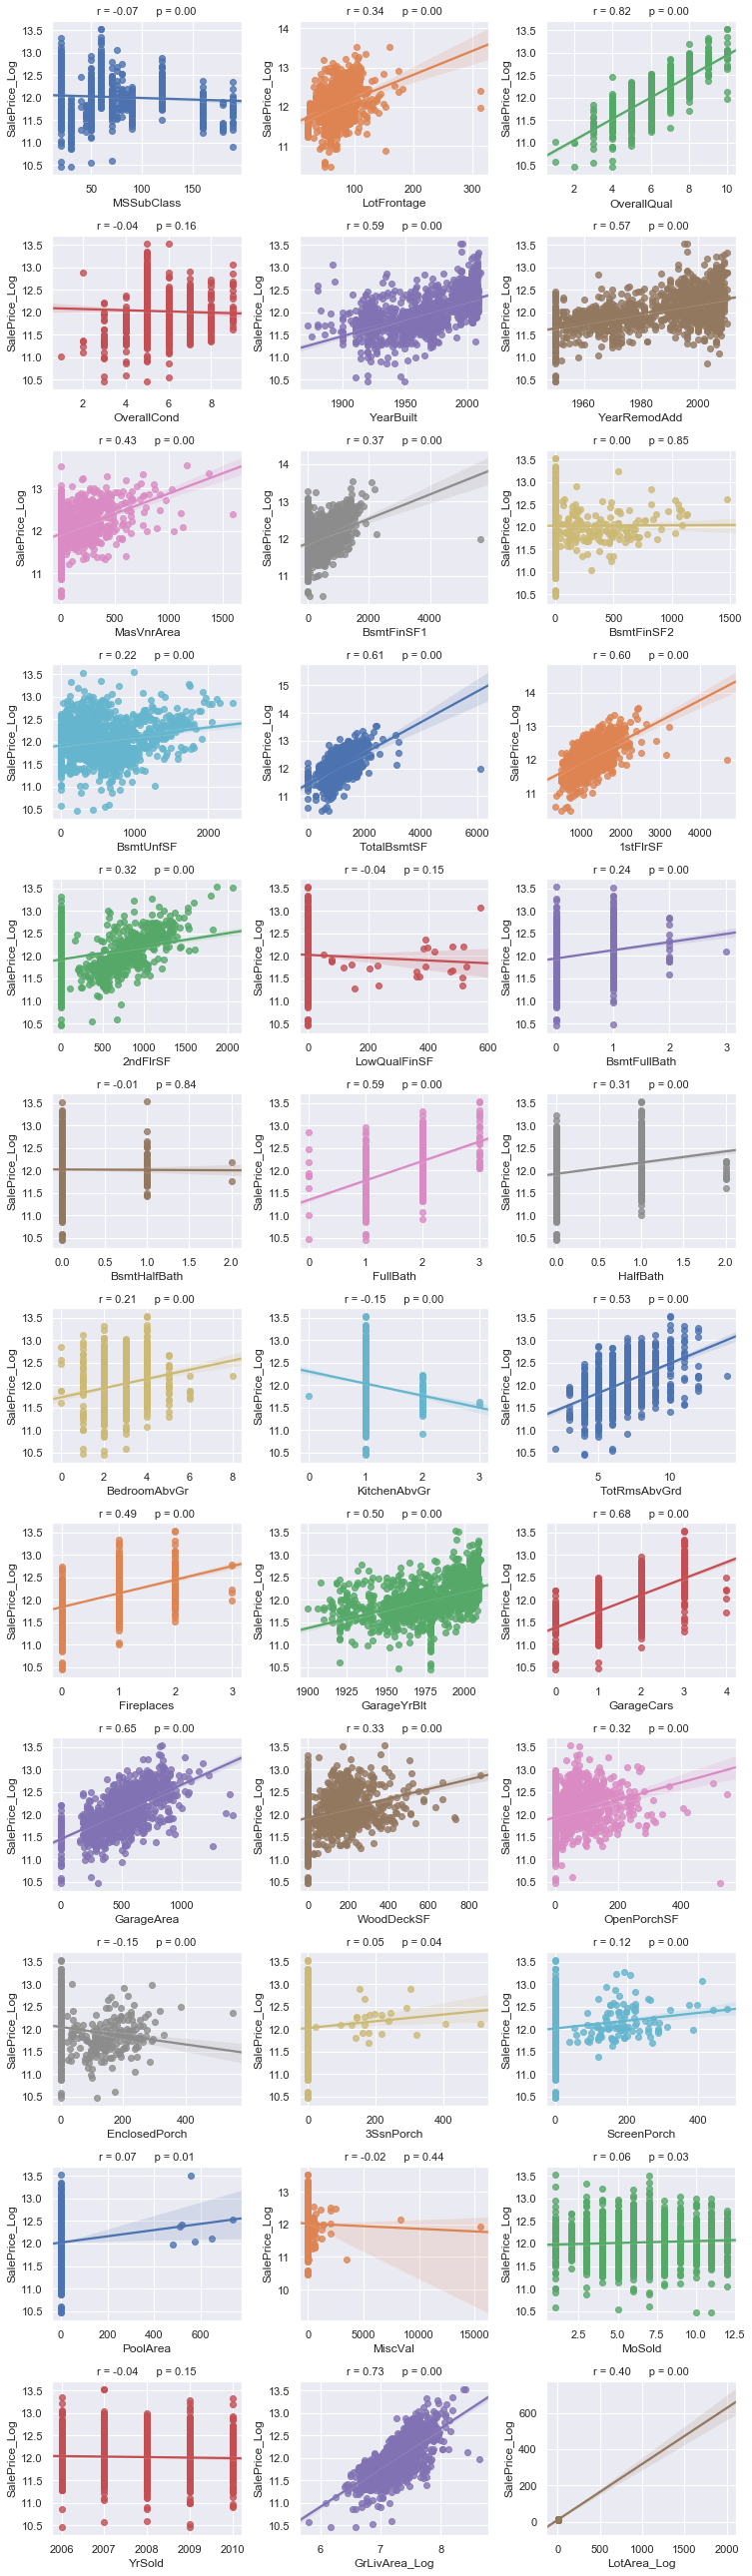

In [112]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

Conclusion from EDA on numerical columns:

We see that for some features like 'OverallQual' there is a strong linear correlation (0.79) to the target. For other features like 'MSSubClass' the correlation is very weak. For this kernel I decided to use only those features for prediction that have a correlation larger than a threshold value to SalePrice. This threshold value can be choosen in the global settings : min_val_corr

With the default threshold for min_val_corr = 0.4, these features are dropped in Part 2, Data Wrangling: 'Id', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

We also see that the entries for some of the numerical columns are in fact categorical values. For example, the numbers for 'OverallQual' and 'MSSubClass' represent a certain group for that feature

Outliers

Find columns with strong correlation to target Only those with r > min_val_corr are used in the ML Regressors in Part 3 The value for min_val_corr can be chosen in global settings

In [113]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

List of numerical features and their correlation coefficient to target

In [114]:
print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
SalePrice        0.948374
OverallQual      0.817185
GrLivArea_Log    0.730255
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
LotArea_Log      0.399918
BsmtFinSF1       0.372023
LotFrontage      0.336156
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
EnclosedPorch    0.149050
KitchenAbvGr     0.147548
ScreenPorch      0.121208
MSSubClass       0.073959
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
LowQualFinSF     0.037963
YrSold           0.037263
OverallCond      0.036868
MiscVal          0.020021
BsmtHalfBath     0.005149
BsmtFinSF2       0.004832
Name: SalePr

List of categorical features and their unique values

In [115]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('#'*50)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1454
Grvl       6
Name: Street, dtype: int64
##################################################
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

Relation to SalePrice for all categorical features

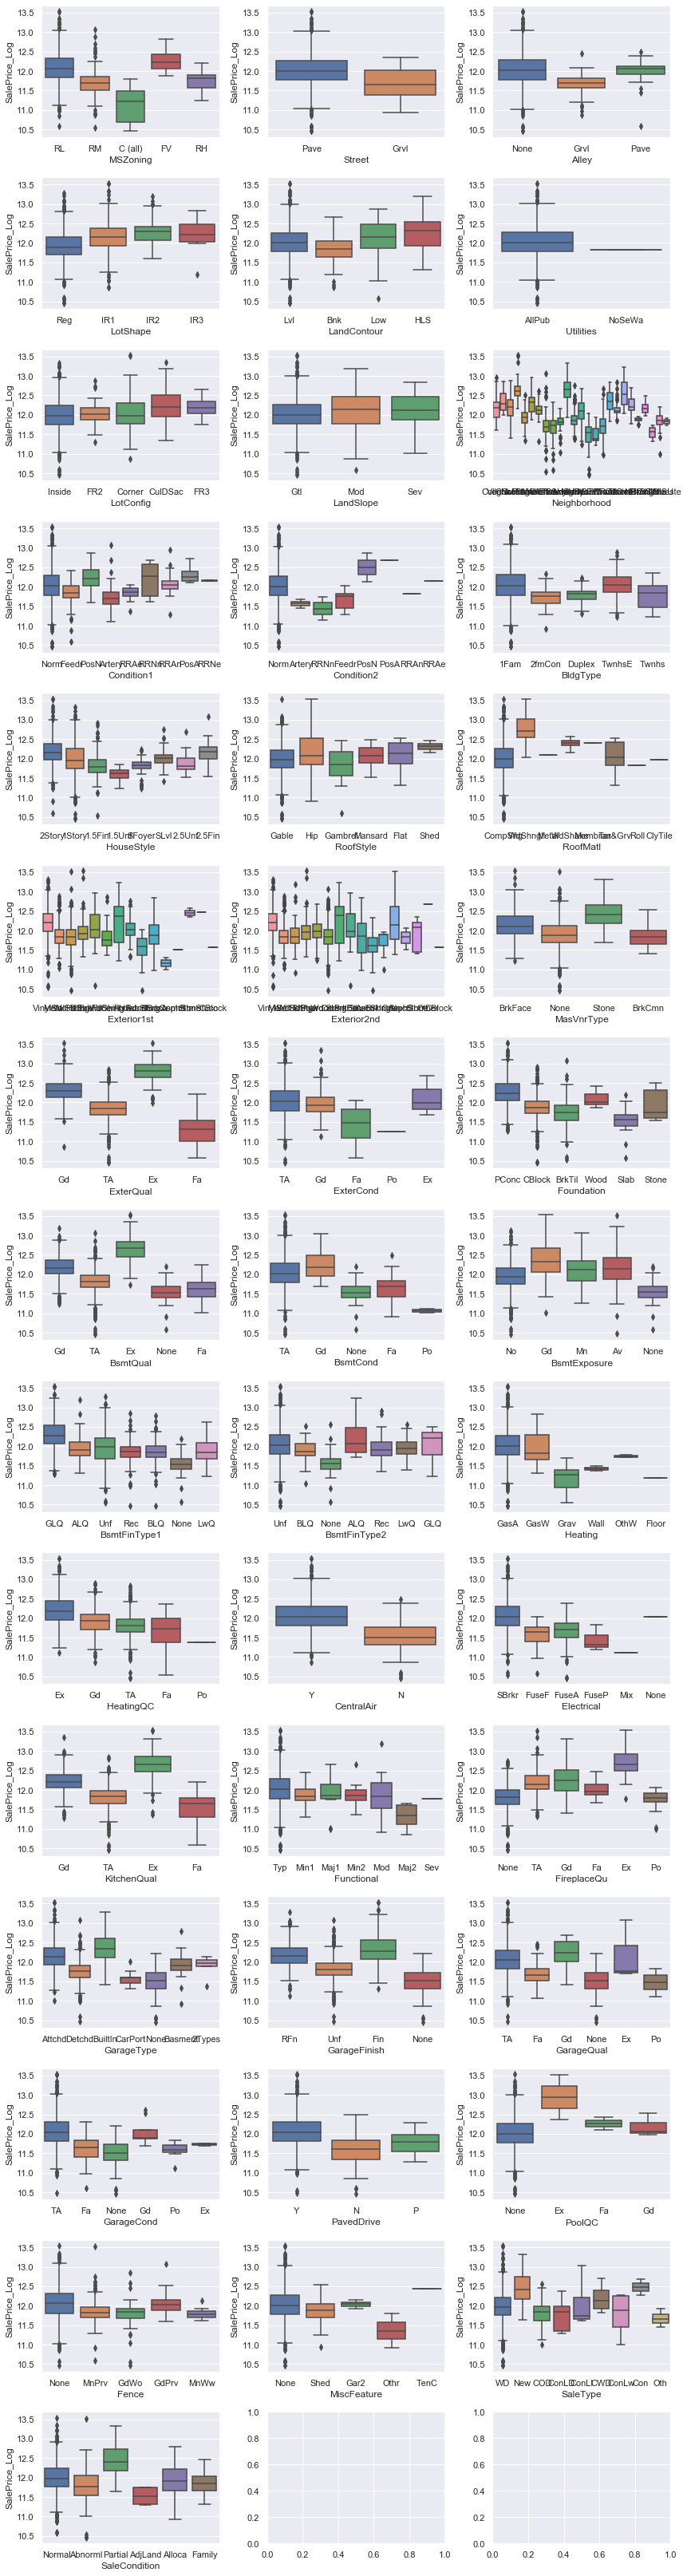

In [116]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

Conclusion from EDA on categorical columns:

For many of the categorical there is no strong relation to the target. However, for some fetaures it is easy to find a strong relation. From the figures above these are : 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType' Also for the categorical features, I use only those that show a strong relation to SalePrice. So the other columns are dropped when creating the ML dataframes in Part 2 : 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition'

In [117]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition']

Correlation matrix 1

Features with largest correlation to SalePrice_Log

all numerical features with correlation coefficient above threshold

In [118]:
nr_feats = len(cols_abv_corr_limit)

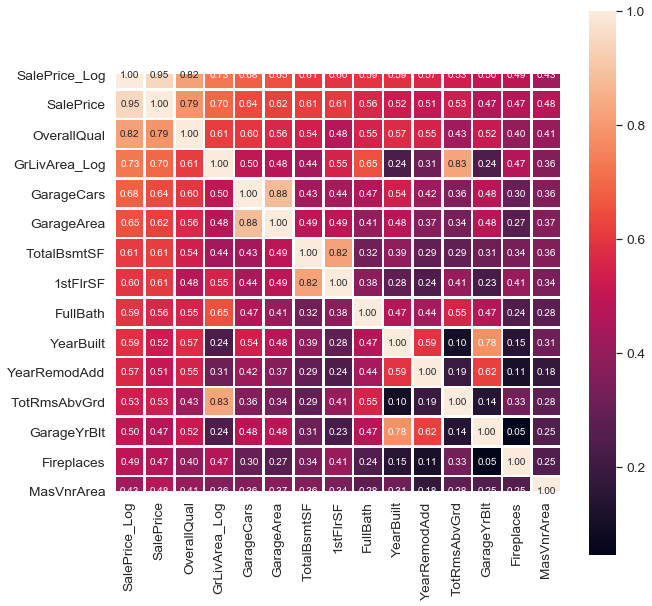

In [119]:
plot_corr_matrix(df_train, nr_feats, target)

Of those features with the largest correlation to SalePrice, some also are correlated strongly to each other.


To avoid failures of the ML regression models due to multicollinearity, these are dropped in part 2.


This is optional and controlled by the switch drop_similar (global settings)

# Data wrangling

Drop all columns with only small correlation to SalePrice
Transform Categorical to numerical
Handling columns with missing data
Log values
Drop all columns with strong correlation to similar features


Numerical columns : drop similar and low correlation


Categorical columns : Transform to numerical


Dropping all columns with weak correlation to SalePrice

In [120]:
id_test = df_test_id_test['Id']

In [122]:
to_drop_num  = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

#cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

cols_to_drop = to_drop_num + to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)


KeyError: "['LotArea_Log' 'BsmtFinSF1' 'LotFrontage' 'WoodDeckSF' 'OpenPorchSF'\n '2ndFlrSF' 'HalfBath' 'BsmtFullBath' 'BsmtUnfSF' 'BedroomAbvGr'\n 'EnclosedPorch' 'KitchenAbvGr' 'ScreenPorch' 'MSSubClass' 'PoolArea'\n 'MoSold' '3SsnPorch' 'LowQualFinSF' 'YrSold' 'OverallCond' 'MiscVal'\n 'BsmtHalfBath' 'BsmtFinSF2' 'Street' 'Alley' 'LotShape' 'LandContour'\n 'Utilities' 'LotConfig' 'LandSlope' 'Condition1' 'BldgType' 'HouseStyle'\n 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'ExterCond'\n 'Foundation' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'\n 'Heating' 'HeatingQC' 'Functional' 'FireplaceQu' 'GarageType'\n 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence'\n 'MiscFeature' 'SaleCondition'] not found in axis"

Convert categorical columns to numerical
For those categorcial features where the EDA with boxplots seem to show a strong dependence of the SalePrice on the
category, we transform the columns to numerical. To investigate the relation of the categories to SalePrice in more detail, we
make violinplots for these features Also, we look at the mean of SalePrice as function of category.

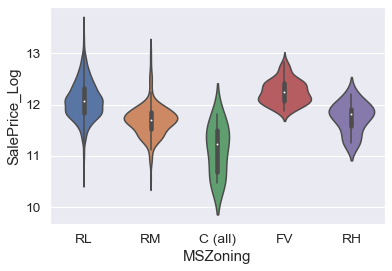

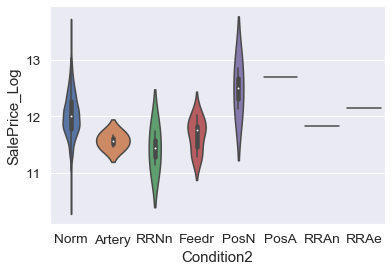

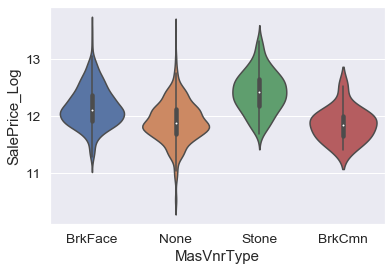

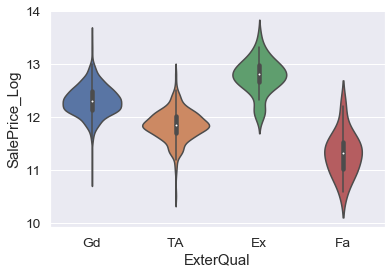

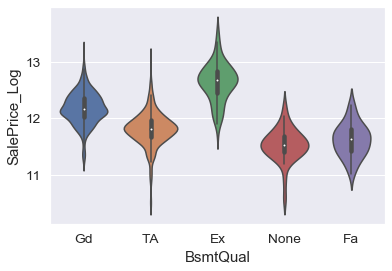

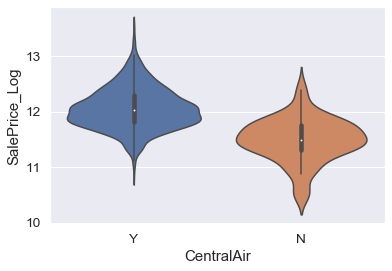

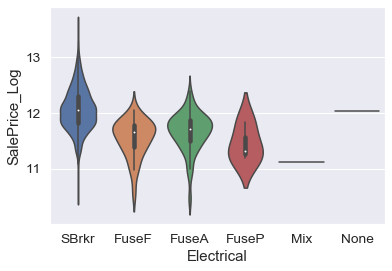

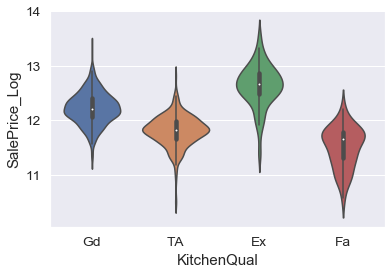

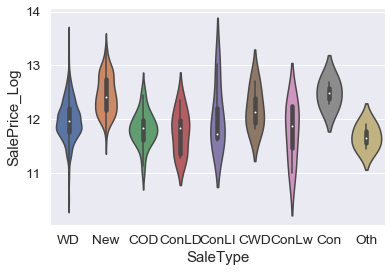

In [123]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
   
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()
   

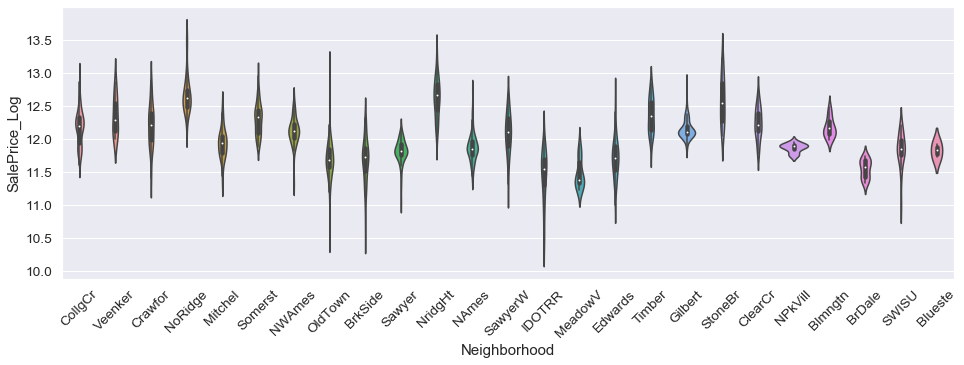

In [124]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [125]:
for catg in catg_list :
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118275
FV         12.246621
RH         11.749848
RL         12.085891
RM         11.692901
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570046
Feedr     11.670639
Norm      12.025902
PosA      12.691584
PosN      12.493883
RRAe      12.154785
RRAn      11.827050
RRNn      11.435340
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853246
BrkFace    12.163635
None       11.896891
Stone      12.425142
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.764047
Fa    11.304554
Gd    12.311287
TA    11.837993
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.640397
Fa      11.617609
Gd      12.179888
None    11.529691
TA      11.810863
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491869
Y    12.061096
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660324
FuseF    11.539635
FuseP    11.446820
Mix      11.112463
None     12.028745
SBrkr    12.061470
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.633617
F

In [126]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [127]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
     
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 

    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  


Checking correlation to SalePrice for the new numerical columns

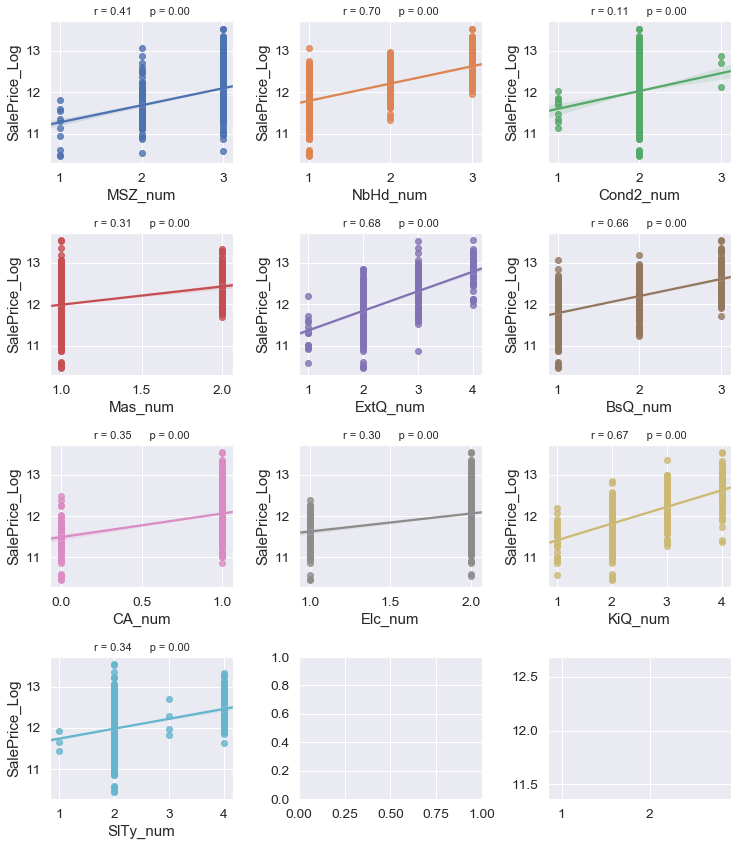

In [128]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

There are few columns with quite large correlation to SalePrice (NbHd_num, ExtQ_num, BsQ_num, KiQ_num).
These will probably be useful for optimal performance of the Regressors in part 3.


Dropping the converted categorical columns and the new numerical columns with weak correlation


columns and correlation before dropping

In [129]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)


for df in [df_train, df_test] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)    

SalePrice_Log    1.000000
SalePrice        0.948374
OverallQual      0.817185
GrLivArea_Log    0.730255
NbHd_num         0.696515
GarageCars       0.680625
ExtQ_num         0.678840
KiQ_num          0.667893
BsQ_num          0.659285
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
MSZ_num          0.409404
CA_num           0.351599
SlTy_num         0.335340
Mas_num          0.311370
Elc_num          0.304861
Cond2_num        0.105442
Name: SalePrice_Log, dtype: float64


columns and correlation after dropping

In [130]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
SalePrice        0.948374
OverallQual      0.817185
GrLivArea_Log    0.730255
NbHd_num         0.696515
GarageCars       0.680625
ExtQ_num         0.678840
KiQ_num          0.667893
BsQ_num          0.659285
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
MSZ_num          0.409404
Name: SalePrice_Log, dtype: float64


new dataframes

In [131]:
df_train.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice,SalePrice_Log,GrLivArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,7,2003,2003,196.0,856,856,2,8,0,2003.0,2,548,208500,12.247699,7.444249,3,2,3,2,3
2,RL,6,1976,1976,0.0,1262,1262,2,6,1,1976.0,2,460,181500,12.109016,7.140453,3,2,2,2,2
3,RL,7,2001,2002,162.0,920,920,2,6,1,2001.0,2,608,223500,12.317171,7.487734,3,2,3,2,3
4,RL,7,1915,1970,0.0,756,961,1,7,1,1998.0,3,642,140000,11.849405,7.448334,3,2,2,1,3
5,RL,8,2000,2000,350.0,1145,1145,2,9,1,2000.0,3,836,250000,12.429220,7.695303,3,3,3,2,3


In [132]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterCond,Foundation,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleCondition,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Feedr,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,CBlock,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,896,0,0,896,0.0,0.0,1,0,2,1,5,Typ,0,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,Normal,2,1,2,1,2
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,CBlock,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,1329,0,0,1329,0.0,0.0,1,1,3,1,6,Typ,0,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,Normal,3,1,2,1,3
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,PConc,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,928,701,0,1629,0.0,0.0,2,1,3,1,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,Normal,3,2,2,2,2
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,20.0,TA,PConc,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,926,678,0,1604,0.0,0.0,2,1,3,1,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,Normal,3,2,2,1,3
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,0.0,TA,PConc,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,1280,0,0,1280,0.0,0.0,2,0,2,1,5,Typ,0,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,Normal,3,3,3,2,3


List of all features with strong correlation to SalePrice_Log

after dropping all coumns with weak correlation

In [133]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print (corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
SalePrice        0.948374
OverallQual      0.817185
GrLivArea_Log    0.730255
NbHd_num         0.696515
GarageCars       0.680625
ExtQ_num         0.678840
KiQ_num          0.667893
BsQ_num          0.659285
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
MSZ_num          0.409404
Name: SalePrice_Log, dtype: float64


Correlation Matrix 2 : All features with strong correlation to SalePrice

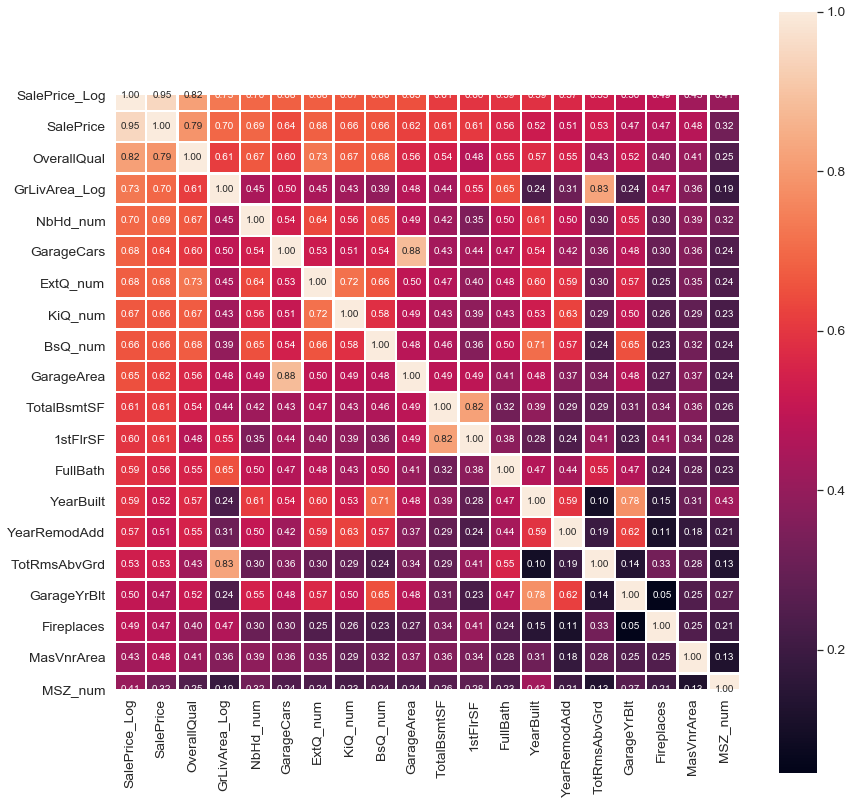

In [134]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

Check for Multicollinearity


Strong correlation of these features to other, similar features:


'GrLivArea_Log' and 'TotRmsAbvGrd'


'GarageCars' and 'GarageArea'


'TotalBsmtSF' and '1stFlrSF'


'YearBuilt' and 'GarageYrBlt'


Of those features we drop the one that has smaller correlation coeffiecient to Target.

In [135]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [136]:
cols = list(cols)
print(cols)

['SalePrice_Log', 'SalePrice', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'GarageCars', 'ExtQ_num', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num']


List of features used for the Regressors in Part 3

In [137]:
feats = cols.copy()
feats.remove('SalePrice_Log')
feats.remove('SalePrice')

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'GarageCars', 'ExtQ_num', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num']


In [138]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterCond,Foundation,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleCondition,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Feedr,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,CBlock,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,896,0,0,896,0.0,0.0,1,0,2,1,5,Typ,0,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,Normal,2,1,2,1,2
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,CBlock,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,1329,0,0,1329,0.0,0.0,1,1,3,1,6,Typ,0,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,Normal,3,1,2,1,3
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,PConc,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,928,701,0,1629,0.0,0.0,2,1,3,1,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,Normal,3,2,2,2,2
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,20.0,TA,PConc,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,926,678,0,1604,0.0,0.0,2,1,3,1,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,Normal,3,2,2,1,3
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,0.0,TA,PConc,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,1280,0,0,1280,0.0,0.0,2,0,2,1,5,Typ,0,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,Normal,3,3,3,2,3


In [139]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()
y = df_train[target]

print(target)

KeyError: "['GrLivArea_Log'] not in index"

In [140]:
# Dataframe dimensions
print(df_train.shape)
print("*"*50)
print(df_test.shape)
print("*"*50)
print(df_train_ml.shape)
print("*"*50)
print(df_test_ml.shape)

(1460, 21)
**************************************************
(1459, 75)
**************************************************
(1460, 14)
**************************************************


NameError: name 'df_test_ml' is not defined

In [141]:
numerical_feats = df_train_ml.dtypes[df_train_ml.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train_ml.dtypes[df_train_ml.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  14
Number of Categorical features:  0


In [142]:
df_all = pd.concat([df_train_ml, df_test_ml])

len_train = df_train_ml.shape[0]

xtrain = df_all[:len_train]
xtest = df_all[len_train:]

NameError: name 'df_test_ml' is not defined

In [143]:
# Dataframe dimensions
print(xtrain.shape)
print("*"*50)
print(xtest.shape)

NameError: name 'xtrain' is not defined

In [144]:
xtrain.head()

NameError: name 'xtrain' is not defined

In [145]:
xtrain.head()

NameError: name 'xtrain' is not defined

In [146]:
# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
data_scaled = scaler.fit_transform(df_all)

# Display first 5 rows of item_data_scaled
data_scaled[:5]

NameError: name 'df_all' is not defined

In [147]:
# Plot scatterplot of scaled x1 against scaled x2
plt.scatter(data_scaled[:,0], data_scaled[:,1])

# Put plot axes on the same scale
plt.axis('equal')

# Label axes
plt.xlabel('x1 (scaled)')
plt.ylabel('x2 (scaled)')

# Clear text residue
plt.show()

NameError: name 'data_scaled' is not defined

In [148]:
total = df_all.isnull().sum().sort_values(ascending=False)
percent = (df_all.isnull().sum()/df_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

NameError: name 'df_all' is not defined

In [149]:
# Initialize instance of PCA transformation
from sklearn.decomposition import PCA
pca = PCA()

# Fit the instance
pca.fit(data_scaled)

NameError: name 'data_scaled' is not defined

In [ ]:
# Display principal components
pca.components_

In [150]:
# Plot scaled dataset and make it partially transparent
plt.scatter(data_scaled[:,0], data_scaled[:,1], alpha=0.3)

# Plot first principal component in black
plt.plot([0, 2*pca.components_[0,0]], [0, 2*pca.components_[0,1]], 'k')

# Plot second principal component in red
plt.plot([0, pca.components_[1,0]], [0, pca.components_[1,1]], 'r')

# Set axes
plt.axis('equal')
plt.xlabel('x1 (scaled)')
plt.ylabel('x2 (scaled)')

# Clear text residue
plt.show()

NameError: name 'data_scaled' is not defined

In [151]:
# Generate new features
PC = pca.transform(data_scaled)

# Display first 5 rows
PC[:5]

NameError: name 'data_scaled' is not defined

In [152]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [153]:
# How much variance we'd capture with the first 8 components
cumulative_explained_variance[8]

NameError: name 'cumulative_explained_variance' is not defined

In [154]:
# Initialize PCA transformation, only keeping 8 components
pca = PCA(n_components=8)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(data_scaled)

# Display shape of PC_items
PC_items.shape

NameError: name 'data_scaled' is not defined

In [155]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = df_all.index

# Display first 5 rows
items_pca.head()

NameError: name 'PC_items' is not defined

In [156]:
len_train = df_train_ml.shape[0]

pca_xtrain = items_pca[:len_train]
pca_xtest = items_pca[len_train:]

NameError: name 'items_pca' is not defined

In [157]:
# Dataframe dimensions
print(pca_xtrain.shape)
print("*"*50)
print(pca_xtest.shape)

NameError: name 'pca_xtrain' is not defined

In [158]:
# Plot transformed dataset
plt.scatter(PC[:,0], PC[:,1], alpha=0.3, color='g')

# Plot first principal component in black
plt.plot([0, 2], [0, 0], 'k')

# Plot second principal component in red
plt.plot([0, 0], [0, 1], 'r')

# Set axes
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Clear text residue
plt.show()

NameError: name 'PC' is not defined

In [159]:
# Display explained variance ratio
pca.explained_variance_ratio_

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'